In [32]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import LabelBinarizer
#import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# To load Input data

In [33]:
dataset_test = pd.read_csv('../data/tcd-ml-1920-group-income-train.csv')
dataset_pred = pd.read_csv('../data/tcd-ml-1920-group-income-test.csv')
store_data = dataset_pred.filter(['Instance'], axis=1)
dataset_test.columns = dataset_test.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
dataset_pred.columns = dataset_pred.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

dataset_test.rename(columns={'Work_Experience_in_Current_Job_[years]': 'Work_Experience_in_Current_Job'}, inplace=True)
dataset_pred.rename(columns={'Work_Experience_in_Current_Job_[years]': 'Work_Experience_in_Current_Job'}, inplace=True)

/users/ugrad/farrej10/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/users/ugrad/farrej10/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Remove Instance Column

In [34]:
dataset_test = dataset_test.drop('Instance', 1)
dataset_pred = dataset_pred.drop('Instance', 1)
dataset_test.drop(dataset_test.loc[dataset_test['Total_Yearly_Income_[EUR]']==2548791].index, inplace=True)

# Change null to rand value between std dev around mean. Alternate could be panda interpolate


In [35]:
Column_Name_avg = dataset_test['Year_of_Record'].mean()
Column_Name_std = dataset_test['Year_of_Record'].std()
Column_Name_null_count = dataset_test['Year_of_Record'].isnull().sum()
Column_Name_null_random_list = np.random.randint(Column_Name_avg - Column_Name_std, Column_Name_avg + Column_Name_std, size=Column_Name_null_count)
dataset_test['Year_of_Record'][np.isnan(dataset_test['Year_of_Record'])] = Column_Name_null_random_list
dataset_test['Year_of_Record'] = dataset_test['Year_of_Record'].astype(int)

Column_Name_avg = dataset_pred['Year_of_Record'].mean()
Column_Name_std = dataset_pred['Year_of_Record'].std()
Column_Name_null_count = dataset_pred['Year_of_Record'].isnull().sum()
Column_Name_null_random_list = np.random.randint(Column_Name_avg - Column_Name_std, Column_Name_avg + Column_Name_std, size=Column_Name_null_count)
dataset_pred['Year_of_Record'][np.isnan(dataset_pred['Year_of_Record'])] = Column_Name_null_random_list
dataset_pred['Year_of_Record'] = dataset_pred['Year_of_Record'].astype(int)

/users/ugrad/farrej10/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/users/ugrad/farrej10/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


# Filling Gender Nan and other values


In [36]:
dataset_test.Gender = dataset_test.Gender.replace("f", "female")
dataset_test["Gender"].fillna("unknown", inplace = True)
dataset_test.Gender = dataset_test.Gender.replace("0", "unknown")

dataset_pred.Gender = dataset_pred.Gender.replace("f", "female")
dataset_pred["Gender"].fillna("unknown", inplace = True)
dataset_pred.Gender = dataset_pred.Gender.replace("0", "unknown")

# Filling University Degree Nan Values

In [37]:
dataset_test.University_Degree = dataset_test.University_Degree.replace("0", "No")
dataset_test["University_Degree"].fillna("No", inplace = True)

dataset_pred.University_Degree = dataset_pred.University_Degree.replace("0", "No")
dataset_pred["University_Degree"].fillna("No", inplace = True)

# Filling Haircolor Nan Values

In [38]:
dataset_test.Hair_Color = dataset_test.Hair_Color.replace("0", "Unknown")
dataset_test["Hair_Color"].fillna("Unknown", inplace = True)
dataset_test = dataset_test.drop('Hair_Color', 1)

dataset_pred.Hair_Color = dataset_pred.Hair_Color.replace("0", "Unknown")
dataset_pred["Hair_Color"].fillna("Unknown", inplace = True)
dataset_pred = dataset_pred.drop('Hair_Color', 1)

# Filling Profession Nan Values

In [39]:
dataset_test["Profession"].fillna("Unknown", inplace = True)
dataset_pred["Profession"].fillna("Unknown", inplace = True)

# Filling Housing_Situation Corrupt Values

In [40]:
dataset_test["Housing_Situation"] = dataset_test["Housing_Situation"].replace(0,'Unknown')
dataset_test["Housing_Situation"] = dataset_test["Housing_Situation"].replace('0','Unknown')
dataset_test["Housing_Situation"] = dataset_test["Housing_Situation"].replace('nA','Unknown')

dataset_pred["Housing_Situation"] = dataset_pred["Housing_Situation"].replace(0,'Unknown')
dataset_pred["Housing_Situation"] = dataset_pred["Housing_Situation"].replace('0','Unknown')
dataset_pred["Housing_Situation"] = dataset_pred["Housing_Situation"].replace('nA','Unknown')


dataset_test['Satisfation_with_employer'] = dataset_test['Satisfation_with_employer'].fillna(method='ffill')
dataset_pred['Satisfation_with_employer'] = dataset_pred['Satisfation_with_employer'].fillna(method='ffill')

# Convert work Experience in current job to float and replace #NUM! to mean of their Age

In [41]:
dataset_test.Work_Experience_in_Current_Job = dataset_test.Work_Experience_in_Current_Job.replace("#NUM!", None)
dataset_test['Work_Experience_in_Current_Job'] = dataset_test['Work_Experience_in_Current_Job'].astype(float)
dataset_test.value = dataset_test.groupby('Age')['Work_Experience_in_Current_Job'].apply(lambda x: x.fillna(x.median()))
dataset_test.value = dataset_test.Work_Experience_in_Current_Job.fillna(dataset_test.Work_Experience_in_Current_Job.median())

dataset_pred.Work_Experience_in_Current_Job = dataset_pred.Work_Experience_in_Current_Job.replace("#NUM!", None)
dataset_pred['Work_Experience_in_Current_Job'] = dataset_pred['Work_Experience_in_Current_Job'].astype(float)
dataset_pred.value = dataset_pred.groupby('Age')['Work_Experience_in_Current_Job'].apply(lambda x: x.fillna(x.median()))
dataset_pred.value = dataset_pred.Work_Experience_in_Current_Job.fillna(dataset_pred.Work_Experience_in_Current_Job.median())

/users/ugrad/farrej10/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until
/users/ugrad/farrej10/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


# Remove EUR in Yearly_Income to make it numerical value 

In [42]:
dataset_test['Yearly_Income_in_addition_to_Salary_e.g._Rental_Income'] = dataset_test['Yearly_Income_in_addition_to_Salary_e.g._Rental_Income'].replace('EUR', '', regex=True).astype(float)
dataset_pred['Yearly_Income_in_addition_to_Salary_e.g._Rental_Income'] = dataset_pred['Yearly_Income_in_addition_to_Salary_e.g._Rental_Income'].replace('EUR', '', regex=True).astype(float)

# Label encoding the categorical columns

In [43]:
for col in dataset_test.dtypes[dataset_test.dtypes == 'object'].index.tolist():
    feat_le = LabelEncoder()
    train_list = dataset_test[col].unique()
    dataset_test.loc[1201,col] = 'other'
    test_list = dataset_pred[col].unique()
    test_replace = list(set(test_list) - set(train_list))
    dataset_pred[col] = dataset_pred[col].replace(test_replace, 'other')
    feat_le.fit(dataset_test[col].unique().astype(str))
    dataset_test[col] = feat_le.transform(dataset_test[col].astype(str))
    dataset_pred[col] = feat_le.transform(dataset_pred[col].astype(str))



### This function takes a string column name and returns a list
### containing indices of dataframe that have outliers in that column
### Refer: https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623


In [44]:
def OutlierByColumn(colname):
    rows = dataset_test.shape[0]
    col_std = np.std(dataset_test[colname])
    col_mean = np.mean(dataset_test[colname])
    anomaly_cut_off = col_std * 3
    lower_limit  = col_mean - anomaly_cut_off 
    upper_limit = col_mean + anomaly_cut_off
    anomalies_indices = []
    for i in range(rows):
        ele = dataset_test[colname][i]
        if ele > upper_limit or ele < lower_limit:
            anomalies_indices.append(i)
    return anomalies_indices

# Running outlier

In [45]:
arr1 = OutlierByColumn('Work_Experience_in_Current_Job')
arr2 = OutlierByColumn('Age')
#arr3 = OutlierByColumn('Body_Height_[cm]')
arr4 = OutlierByColumn('Yearly_Income_in_addition_to_Salary_e.g._Rental_Income')
arr5 = OutlierByColumn('Size_of_City')

In [46]:
#Union of all lists 
union_index = np.union1d(arr1,arr2)
#union_index = np.union1d(union_index,arr3)
union_index = np.union1d(union_index,arr4)
union_index = np.union1d(union_index,arr5)
len(union_index)
dataset_test = dataset_test.drop(union_index)

# Normalise columns

In [47]:
y = dataset_test['Total_Yearly_Income_[EUR]'].values
dataset_test.drop('Total_Yearly_Income_[EUR]', axis=1, inplace=True)


In [48]:

x = dataset_test.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset_test = pd.DataFrame(x_scaled)
X = dataset_test[dataset_test.columns].values

# View Data

In [49]:
dataset_test.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.875,0.171875,0.531250,0.75,0.666667,0.436620,0.005747,0.004655,0.450923,0.50,1.0,0.526316,0.0
1,0.0,0.875,0.130208,0.153125,0.75,0.000000,0.042254,0.005747,0.421465,0.459779,0.50,0.0,0.473684,0.0
2,0.0,0.875,0.177083,0.656250,0.75,0.000000,0.478873,0.005747,0.152092,0.881919,0.00,0.0,0.326316,0.0
3,0.0,0.875,0.364583,0.562500,0.00,0.000000,0.394366,0.011494,0.011000,0.744649,0.50,1.0,0.368421,0.0
4,0.0,0.875,0.265625,0.250000,0.25,0.666667,0.014085,0.011494,0.004344,0.561624,0.25,1.0,0.515789,0.0


In [50]:
y.view()

array([  6182.05,   6819.69,   8663.53, ..., 254738.53,  11182.98,
         1280.21])

In [51]:

X = dataset_test[dataset_test.columns].values

In [52]:
print(y.shape)
print(X.shape)

(997110,)
(997110, 14)


In [53]:
#split 80% of the data to the training set while 20% of the data to test set.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1)

In [55]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(897399, 14) (99711, 14)
(897399,) (99711,)


In [56]:
dataset_pred.drop('Total_Yearly_Income_[EUR]', axis=1, inplace=True)

x = dataset_pred.values #returns a numpy array
x_scaled = min_max_scaler.transform(x)
dataset_pred = pd.DataFrame(x_scaled)

X_pred = dataset_pred[dataset_pred.columns].values

# KERAS Model

In [57]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.layers import Dropout
from keras import losses

In [58]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
losses = losses.mean_absolute_percentage_error

In [59]:
model = Sequential()
model.add(Dense(500,kernel_initializer='RandomUniform', input_dim=14, activation= "relu"))
model.add(Dropout(0.2))
model.add(Dense(250,kernel_initializer='normal', activation= "relu"))
model.add(Dense(1))

In [60]:
model.compile(loss= losses , optimizer=sgd, metrics=["mean_absolute_error"])

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               7500      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 251       
Total params: 133,001
Trainable params: 133,001
Non-trainable params: 0
_________________________________________________________________


In [108]:
hist = model.fit(X_train, Y_train,
          batch_size=1024, epochs=500,
          validation_split=0.2,shuffle=True)

Train on 717919 samples, validate on 179480 samples
Epoch 1/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5919 - mean_absolute_error: 15877.4400 - val_loss: 18.4037 - val_mean_absolute_error: 15765.3434
Epoch 2/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5894 - mean_absolute_error: 15881.8754 - val_loss: 18.3168 - val_mean_absolute_error: 15780.0154
Epoch 3/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5875 - mean_absolute_error: 15855.3907 - val_loss: 18.1691 - val_mean_absolute_error: 15729.5677
Epoch 4/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5849 - mean_absolute_error: 15896.6724 - val_loss: 18.2593 - val_mean_absolute_error: 15680.2522
Epoch 5/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.6092 - mean_absolute_error: 15894.6701 - val_loss: 18.3401 - val_mean_absolute_error: 15752.6513
Epoch 6/500
717919/717919 [================

Epoch 46/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5614 - mean_absolute_error: 15876.5264 - val_loss: 18.2476 - val_mean_absolute_error: 15763.7076
Epoch 47/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5813 - mean_absolute_error: 15847.1952 - val_loss: 18.4188 - val_mean_absolute_error: 15706.5564
Epoch 48/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5782 - mean_absolute_error: 15861.8378 - val_loss: 18.3083 - val_mean_absolute_error: 15733.5280
Epoch 49/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5637 - mean_absolute_error: 15872.6001 - val_loss: 18.5946 - val_mean_absolute_error: 15743.2101
Epoch 50/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5333 - mean_absolute_error: 15848.2592 - val_loss: 18.3183 - val_mean_absolute_error: 15688.6557
Epoch 51/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5398 

717919/717919 [==============================] - 1s 2us/step - loss: 18.5816 - mean_absolute_error: 15880.4219 - val_loss: 18.3525 - val_mean_absolute_error: 15750.2632
Epoch 92/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5567 - mean_absolute_error: 15850.2497 - val_loss: 18.5446 - val_mean_absolute_error: 15804.1060
Epoch 93/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5692 - mean_absolute_error: 15848.7262 - val_loss: 18.2533 - val_mean_absolute_error: 15638.1956
Epoch 94/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5463 - mean_absolute_error: 15829.8520 - val_loss: 18.4417 - val_mean_absolute_error: 15668.0162
Epoch 95/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5441 - mean_absolute_error: 15824.0849 - val_loss: 18.6372 - val_mean_absolute_error: 15849.1147
Epoch 96/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5554 - mean_absolu

Epoch 136/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5173 - mean_absolute_error: 15828.2526 - val_loss: 19.1311 - val_mean_absolute_error: 15693.9739
Epoch 137/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5466 - mean_absolute_error: 15854.3164 - val_loss: 18.3967 - val_mean_absolute_error: 15692.3960
Epoch 138/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5384 - mean_absolute_error: 15830.6905 - val_loss: 18.4363 - val_mean_absolute_error: 15567.9879
Epoch 139/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5399 - mean_absolute_error: 15843.8933 - val_loss: 18.3023 - val_mean_absolute_error: 15606.8348
Epoch 140/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5340 - mean_absolute_error: 15825.8955 - val_loss: 18.2424 - val_mean_absolute_error: 15673.9761
Epoch 141/500
717919/717919 [==============================] - 1s 2us/step - loss: 18

Epoch 181/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5227 - mean_absolute_error: 15818.9797 - val_loss: 19.1441 - val_mean_absolute_error: 15672.8484
Epoch 182/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5415 - mean_absolute_error: 15812.4331 - val_loss: 18.4514 - val_mean_absolute_error: 15573.7756
Epoch 183/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5386 - mean_absolute_error: 15804.3416 - val_loss: 18.1116 - val_mean_absolute_error: 15617.2147
Epoch 184/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5191 - mean_absolute_error: 15807.7825 - val_loss: 18.2822 - val_mean_absolute_error: 15681.1783
Epoch 185/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5402 - mean_absolute_error: 15823.6820 - val_loss: 18.2569 - val_mean_absolute_error: 15683.8453
Epoch 186/500
717919/717919 [==============================] - 1s 2us/step - loss: 18

Epoch 226/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5103 - mean_absolute_error: 15804.9939 - val_loss: 18.0823 - val_mean_absolute_error: 15525.6226
Epoch 227/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5045 - mean_absolute_error: 15800.1846 - val_loss: 18.2394 - val_mean_absolute_error: 15705.6422
Epoch 228/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4963 - mean_absolute_error: 15801.2582 - val_loss: 18.3445 - val_mean_absolute_error: 15602.4783
Epoch 229/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5273 - mean_absolute_error: 15783.4183 - val_loss: 18.1122 - val_mean_absolute_error: 15588.9572
Epoch 230/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5142 - mean_absolute_error: 15799.7004 - val_loss: 18.1407 - val_mean_absolute_error: 15642.2511
Epoch 231/500
717919/717919 [==============================] - 1s 2us/step - loss: 18

Epoch 271/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4913 - mean_absolute_error: 15789.8705 - val_loss: 18.1346 - val_mean_absolute_error: 15683.9973
Epoch 272/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4853 - mean_absolute_error: 15798.3026 - val_loss: 18.1443 - val_mean_absolute_error: 15607.1802
Epoch 273/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4743 - mean_absolute_error: 15791.9540 - val_loss: 18.5267 - val_mean_absolute_error: 15648.5355
Epoch 274/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.5417 - mean_absolute_error: 15791.8242 - val_loss: 18.0472 - val_mean_absolute_error: 15543.9608
Epoch 275/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4752 - mean_absolute_error: 15783.1566 - val_loss: 18.4409 - val_mean_absolute_error: 15475.3232
Epoch 276/500
717919/717919 [==============================] - 1s 2us/step - loss: 18

Epoch 316/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4805 - mean_absolute_error: 15778.3808 - val_loss: 19.7204 - val_mean_absolute_error: 15677.1376
Epoch 317/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4863 - mean_absolute_error: 15782.8985 - val_loss: 17.9284 - val_mean_absolute_error: 15546.8331
Epoch 318/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4835 - mean_absolute_error: 15794.1366 - val_loss: 18.0594 - val_mean_absolute_error: 15594.8108
Epoch 319/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4831 - mean_absolute_error: 15775.8080 - val_loss: 18.1861 - val_mean_absolute_error: 15641.0085
Epoch 320/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4735 - mean_absolute_error: 15764.2677 - val_loss: 18.3235 - val_mean_absolute_error: 15670.4954
Epoch 321/500
717919/717919 [==============================] - 1s 2us/step - loss: 18

Epoch 361/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4506 - mean_absolute_error: 15753.7186 - val_loss: 18.4752 - val_mean_absolute_error: 15590.6455
Epoch 362/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4746 - mean_absolute_error: 15760.6337 - val_loss: 18.1115 - val_mean_absolute_error: 15565.8082
Epoch 363/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4908 - mean_absolute_error: 15767.0938 - val_loss: 18.6718 - val_mean_absolute_error: 15601.6678
Epoch 364/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4505 - mean_absolute_error: 15777.3488 - val_loss: 18.2142 - val_mean_absolute_error: 15634.8972
Epoch 365/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4846 - mean_absolute_error: 15755.3858 - val_loss: 18.1799 - val_mean_absolute_error: 15551.1974
Epoch 366/500
717919/717919 [==============================] - 1s 2us/step - loss: 18

Epoch 406/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4163 - mean_absolute_error: 15729.5505 - val_loss: 18.1105 - val_mean_absolute_error: 15565.0317
Epoch 407/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4736 - mean_absolute_error: 15767.1235 - val_loss: 18.1695 - val_mean_absolute_error: 15648.9440
Epoch 408/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4285 - mean_absolute_error: 15744.2935 - val_loss: 18.2622 - val_mean_absolute_error: 15597.8433
Epoch 409/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4286 - mean_absolute_error: 15728.1900 - val_loss: 18.0088 - val_mean_absolute_error: 15528.2908
Epoch 410/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4343 - mean_absolute_error: 15733.6496 - val_loss: 18.1613 - val_mean_absolute_error: 15598.5910
Epoch 411/500
717919/717919 [==============================] - 1s 2us/step - loss: 18

Epoch 451/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4072 - mean_absolute_error: 15732.3211 - val_loss: 18.1211 - val_mean_absolute_error: 15652.6013
Epoch 452/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4362 - mean_absolute_error: 15768.2022 - val_loss: 18.4698 - val_mean_absolute_error: 15635.3412
Epoch 453/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4508 - mean_absolute_error: 15733.1087 - val_loss: 18.1609 - val_mean_absolute_error: 15516.0461
Epoch 454/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4085 - mean_absolute_error: 15716.6760 - val_loss: 18.3011 - val_mean_absolute_error: 15670.0609
Epoch 455/500
717919/717919 [==============================] - 2s 2us/step - loss: 18.4334 - mean_absolute_error: 15743.4369 - val_loss: 18.3067 - val_mean_absolute_error: 15638.1850
Epoch 456/500
717919/717919 [==============================] - 2s 2us/step - loss: 18

Epoch 496/500
717919/717919 [==============================] - 2s 2us/step - loss: 18.3975 - mean_absolute_error: 15731.8711 - val_loss: 18.0485 - val_mean_absolute_error: 15554.1391
Epoch 497/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4260 - mean_absolute_error: 15736.2230 - val_loss: 18.0669 - val_mean_absolute_error: 15455.5553
Epoch 498/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4076 - mean_absolute_error: 15724.9053 - val_loss: 18.2650 - val_mean_absolute_error: 15546.5641
Epoch 499/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.4176 - mean_absolute_error: 15722.2669 - val_loss: 18.1109 - val_mean_absolute_error: 15566.3070
Epoch 500/500
717919/717919 [==============================] - 1s 2us/step - loss: 18.3923 - mean_absolute_error: 15706.6092 - val_loss: 18.3320 - val_mean_absolute_error: 15646.2257


In [104]:
model.evaluate(X_test, Y_test)[1]

99711/99711 [==============================] - 1s 14us/step


15545.416561479864

# Visualizing Loss & Accuracy

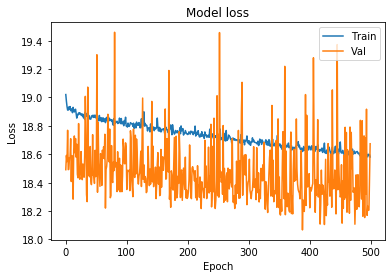

In [105]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Output

In [97]:
#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [106]:
y_pred = model.predict(X_pred)

In [107]:
store_data['Total Yearly Income [EUR]'] = y_pred
store_data.to_csv('output5.csv', sep=',')